In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ruptures as rpt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Wczytujemy i walidujemy zbiór

In [2]:
data = pd.read_csv('https://www.openml.org/data/get_csv/3626/dataset_2175_kin8nm.arff')

In [3]:
data.head()

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,y
0,-0.015119,0.360741,0.469398,1.309675,0.988024,-0.025493,0.664071,0.062763,0.536524
1,0.360478,-0.301395,0.629183,-1.440146,-0.741637,-1.196750,-1.038444,-0.717461,0.308014
2,1.563238,-1.294753,0.078987,1.432937,1.149136,-1.292140,1.562988,-0.937731,0.518900
3,0.199485,0.901157,-1.356304,-0.080525,-0.976628,0.829894,-0.855649,0.930630,0.494151
4,0.659737,0.120552,-0.008756,0.648839,0.626832,-0.646539,1.318074,-0.899172,0.470218


In [4]:
data.isna().sum()

theta1    0
theta2    0
theta3    0
theta4    0
theta5    0
theta6    0
theta7    0
theta8    0
y         0
dtype: int64

In [5]:
y = data['y']
X = data.drop('y', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6144, 8) (2048, 8) (6144,) (2048,)


# Robimy modele

### Las losowy 

In [8]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf = pd.Series(y_pred_rf, y_test.index)

print(mean_squared_error(y_pred_rf, y_test))

c:\users\mateusz\desktop\mimuw\interpretableml\imlteam5\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.02466009154480999


#### Wykres ważności zmiennych z RF

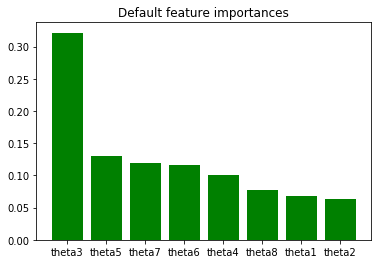

In [9]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Default feature importances")
plt.bar(range(X.shape[1]), 
        importances[indices],
        color="g", 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(X.shape[1]), list(np.array(X.columns)[indices]))
plt.show()

### SVM

In [10]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
y_pred_svr = pd.Series(y_pred_svr, y_test.index)

print(mean_squared_error(y_pred_svr, y_test))

c:\users\mateusz\desktop\mimuw\interpretableml\imlteam5\venv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.007524419745355007


# Przekształcamy zmienne objaśniające przy pomocy ALE plotów

In [11]:
class AccumulatedLocalEffectsPlotter(object):
    def __init__(self, clf, x):
        self.clf = clf
        self.x = x
        
    def draw_accumulated_local_effects_plot(self, column, window_size=3, n_grid=10):
        mini, maxi = min(self.x[column]), max(self.x[column])
        grid = np.linspace(mini, maxi, n_grid)
        ale = []
        
        # find ALE statistics
        for value in grid:
            neighbours = self.x[(self.x[column] >= value - window_size) &
                                (self.x[column] <= value + window_size)].copy()
            
            neighbours[column] = value - window_size
            scores_lower = self.clf.predict(neighbours)
            
            neighbours[column] = value + window_size
            scores_upper = self.clf.predict(neighbours)
            
            
            ale.append((scores_upper - scores_lower).mean())
        
        ale = np.array(ale).cumsum()
        ale = ale - np.array(ale).mean()

        # draw the plot
        plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=grid,
                          y=ale)
        ax.set_title('Accumulated Local Effects plot for variable {}'.format(column))
        ax.set_ylabel(column)
        
        plt.show()
        return ale, grid

### Las losowy

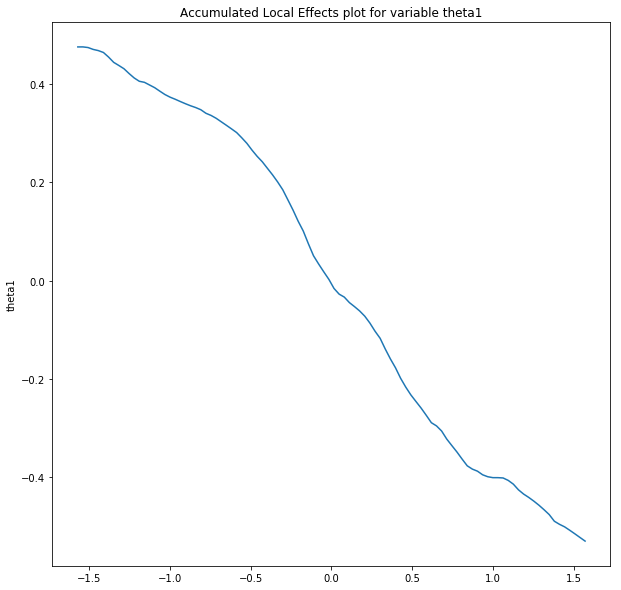

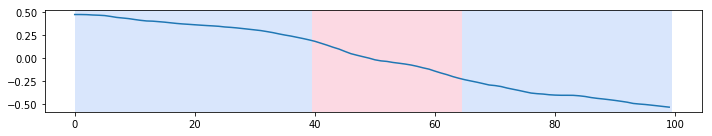

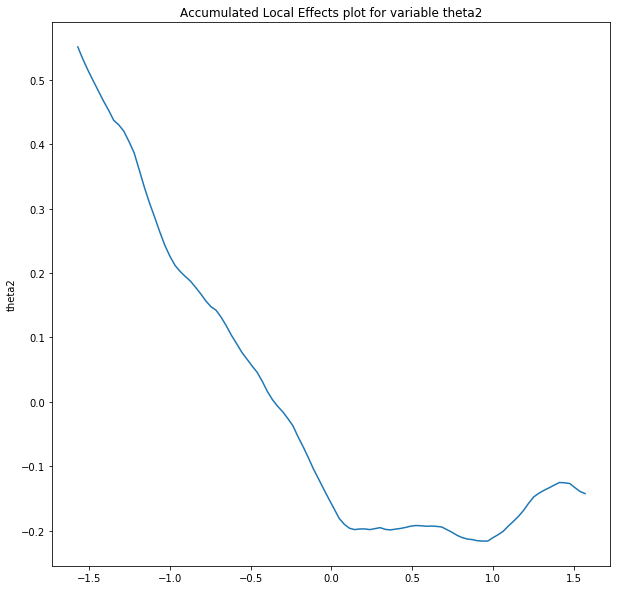

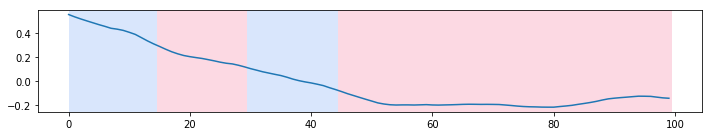

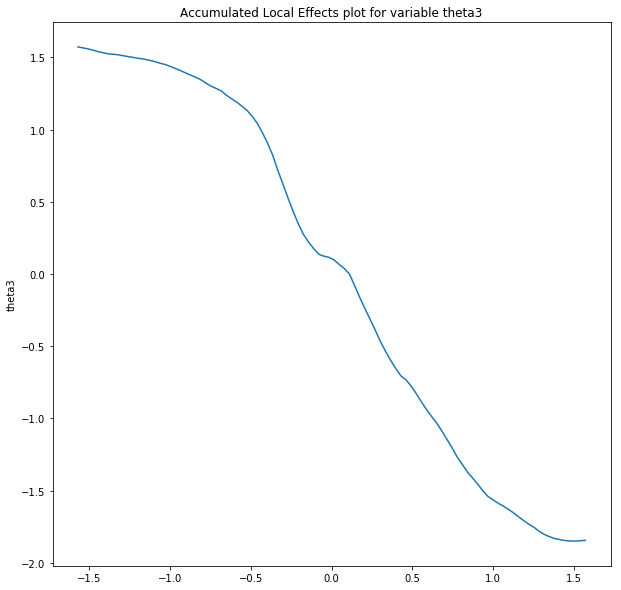

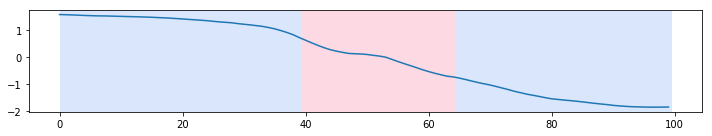

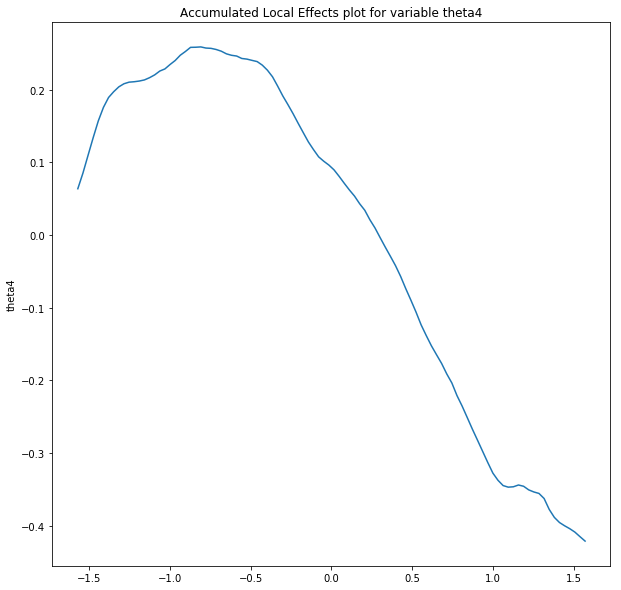

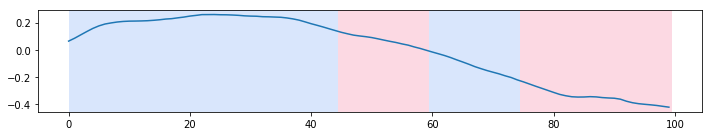

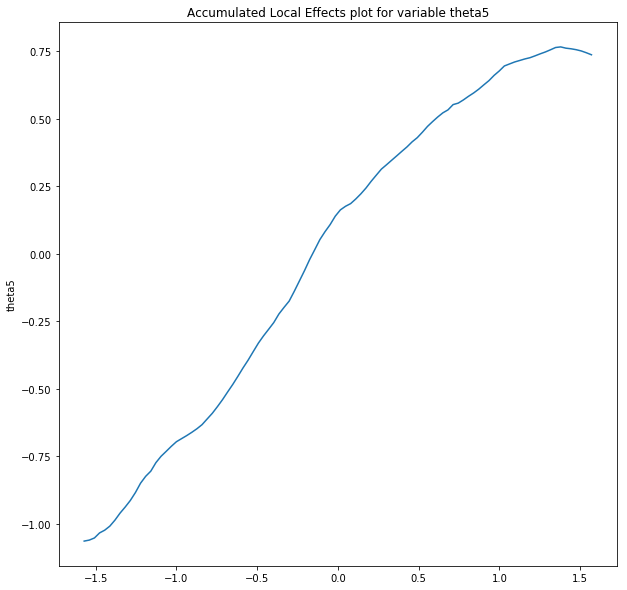

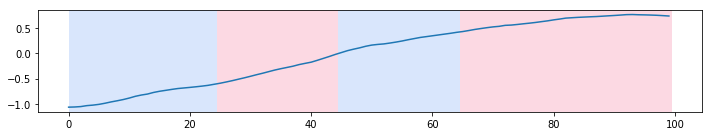

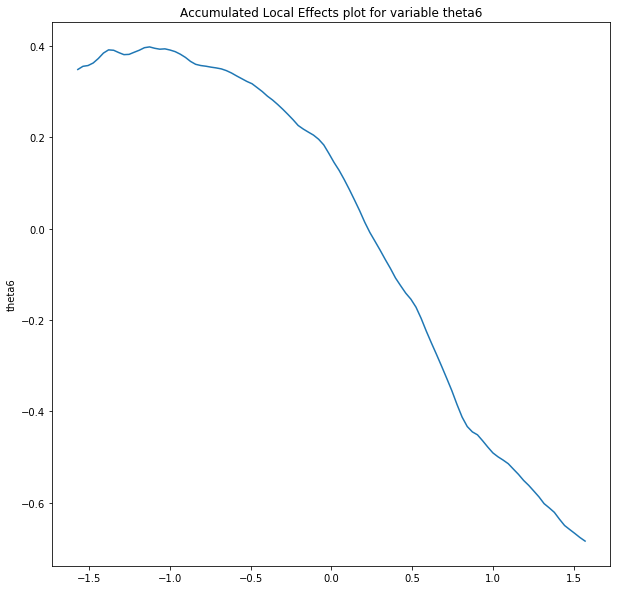

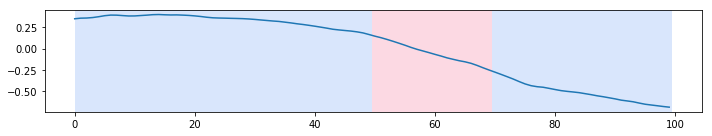

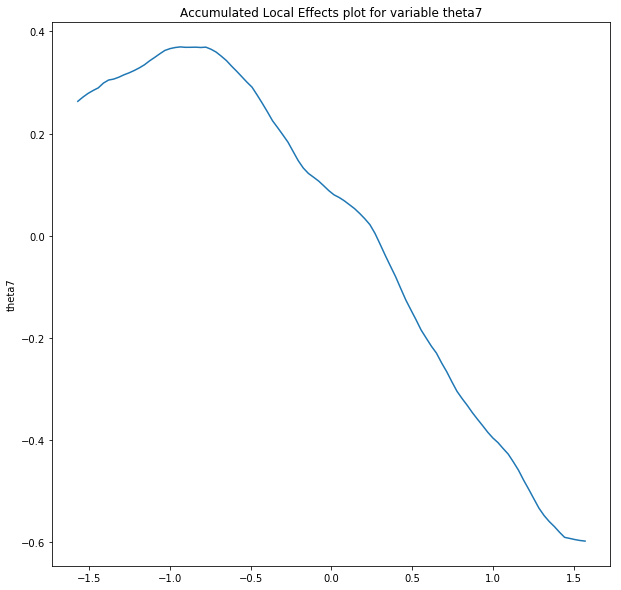

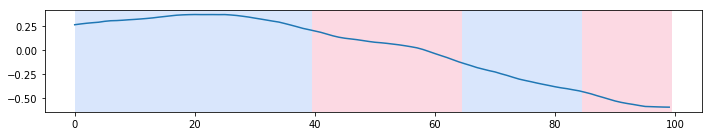

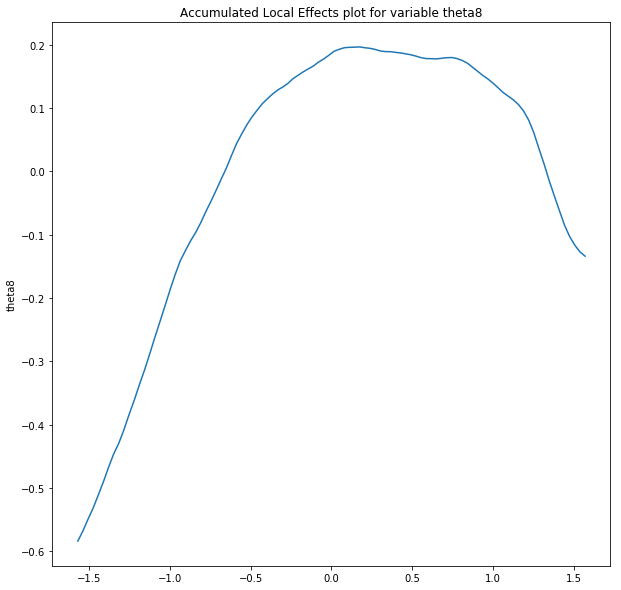

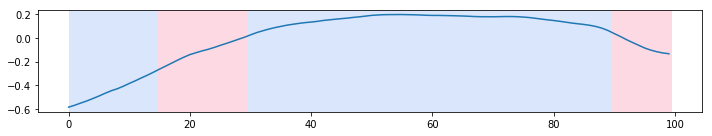

In [12]:
breakpoints_rf = {}
for var in X_test.columns:
    alep = AccumulatedLocalEffectsPlotter(rf, X_train)
    output, grid = alep.draw_accumulated_local_effects_plot(var, 0.15, 100)
    algo = rpt.Pelt(model="rbf").fit(np.array(output))
    result = algo.predict(pen=5)
    rpt.display(output, result)
    plt.show()
    breakpoints_rf[var] = grid[[x - 1 for x in result]]

In [13]:
X_train_transformed_rf = pd.DataFrame()

In [14]:
def transform(x, bpts):
    for i, bpt in enumerate(bpts):
        if x <= bpt:
            return i
        
    return len(bpts)    

In [15]:
for k, v in breakpoints_rf.items():
    X_train_transformed_rf[k] = X_train[k].apply(transform, bpts=v)

### SVM

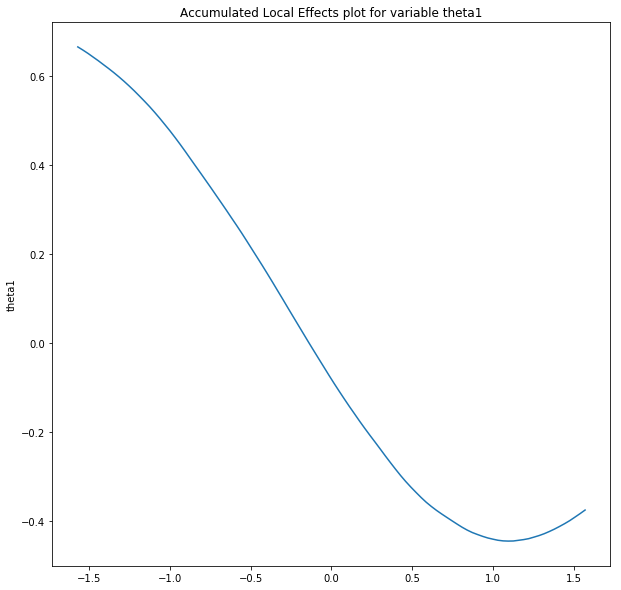

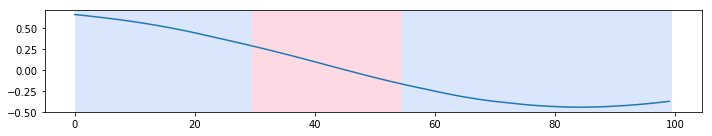

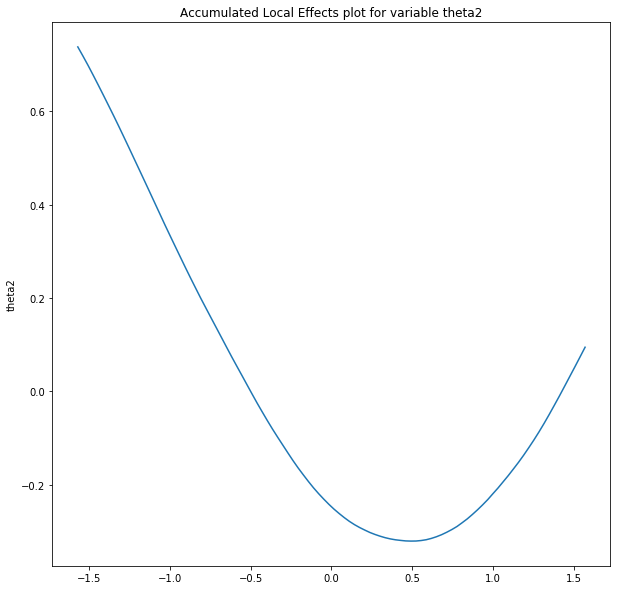

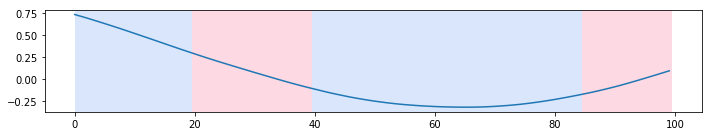

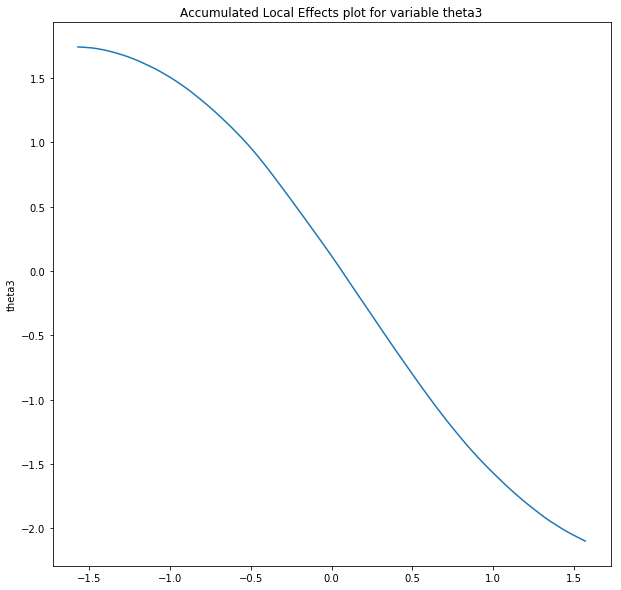

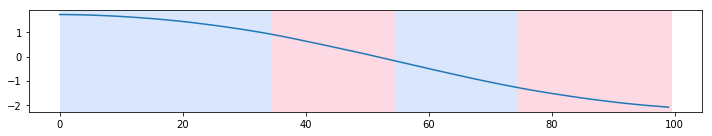

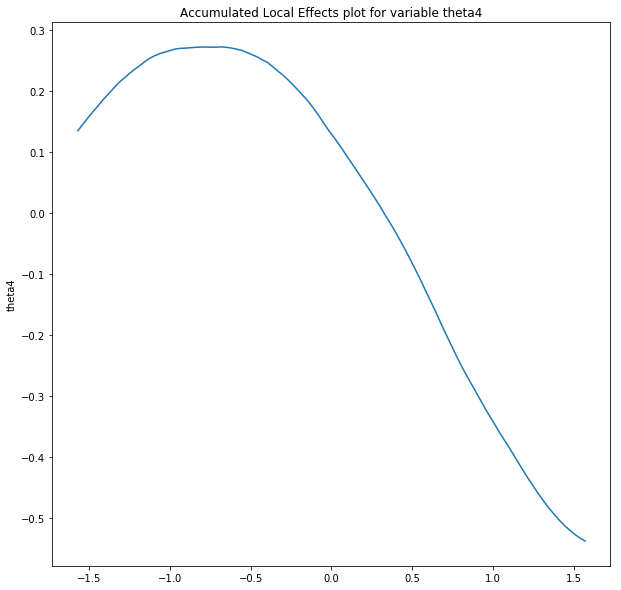

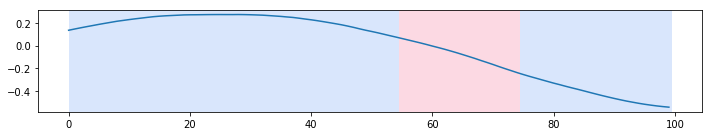

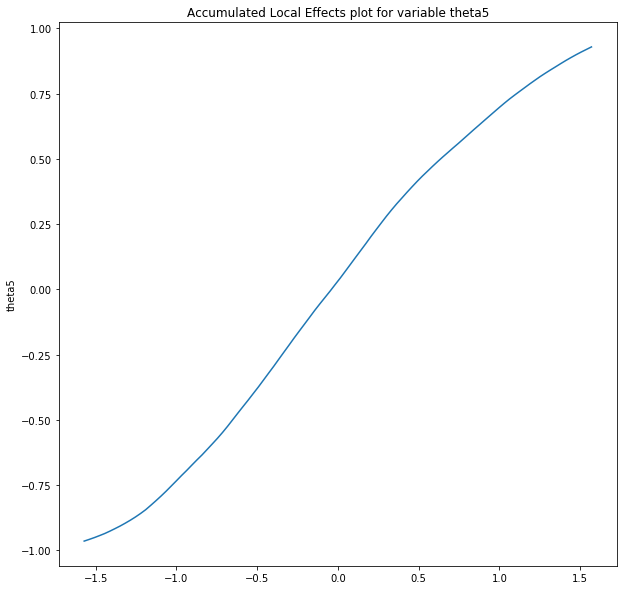

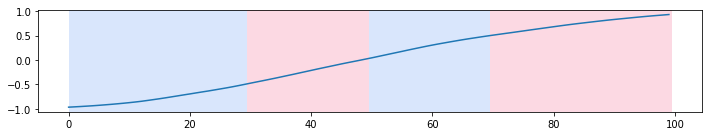

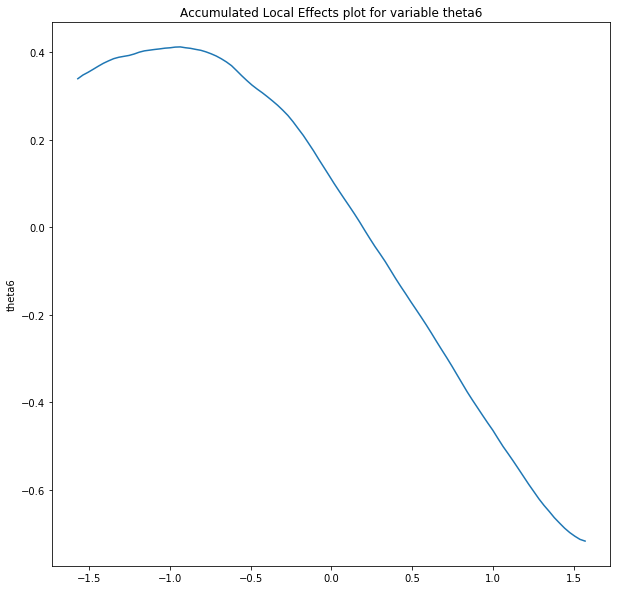

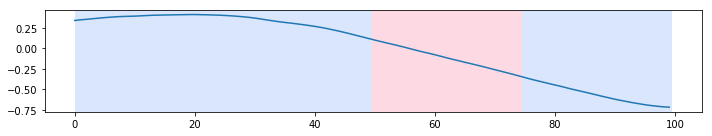

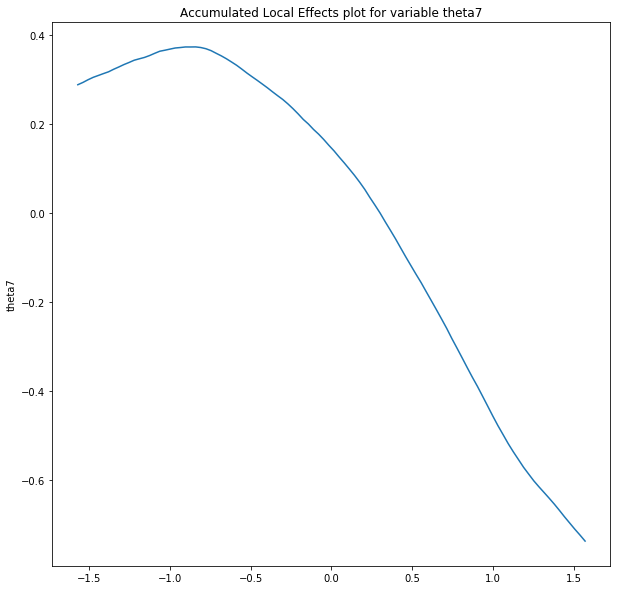

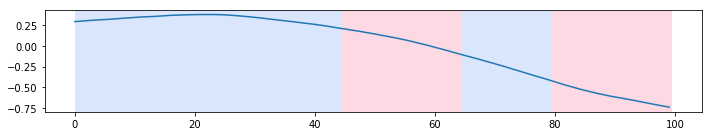

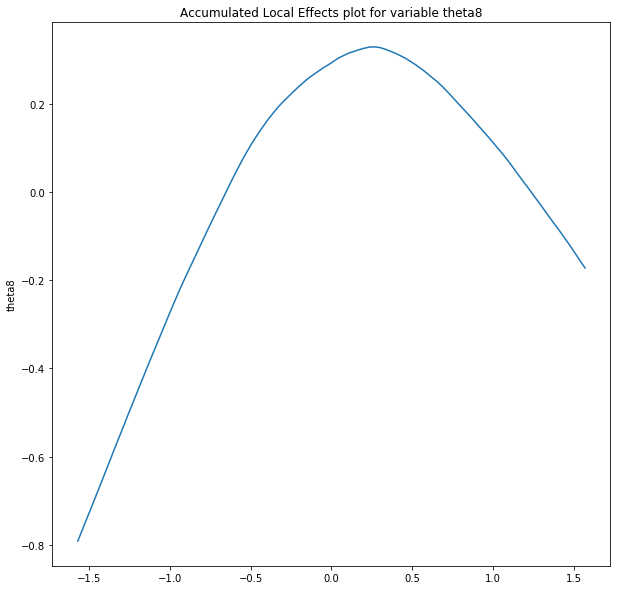

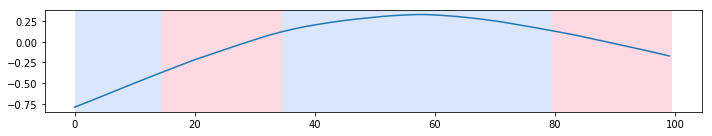

In [16]:
breakpoints_svr = {}
for var in X_test.columns:
    alep = AccumulatedLocalEffectsPlotter(svr, X_train)
    output, grid = alep.draw_accumulated_local_effects_plot(var, 0.15, 100)
    algo = rpt.Pelt(model="rbf").fit(np.array(output))
    result = algo.predict(pen=5)
    rpt.display(output, result)
    plt.show()
    breakpoints_svr[var] = grid[[x - 1 for x in result]]

In [17]:
X_train_transformed_svr = pd.DataFrame()

In [18]:
for k, v in breakpoints_svr.items():
    X_train_transformed_svr[k] = X_train[k].apply(transform, bpts=v)

# Robimy prosty model (regresję) na zbinowanych zmiennych

### Las losowy

In [19]:
errors_rf = []

In [20]:
errors_rf.append(mean_squared_error(y_pred_rf, y_test))
print(mean_squared_error(y_pred_rf, y_test))

0.02466009154480999


In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr = pd.Series(y_pred_lr, y_test.index)
errors_rf.append(mean_squared_error(y_pred_lr, y_test))

print(mean_squared_error(y_pred_lr, y_test))

0.040597205799391134


In [22]:
lr = LinearRegression()
lr.fit(X_train_transformed_rf, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr = pd.Series(y_pred_lr, y_test.index)
errors_rf.append(mean_squared_error(y_pred_lr, y_test))

print(mean_squared_error(y_pred_lr, y_test))

0.0889985644818475


### SVM

In [23]:
errors_svm = []

In [24]:
errors_svm.append(mean_squared_error(y_pred_svr, y_test))
print(mean_squared_error(y_pred_svr, y_test))

0.007524419745355007


In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr = pd.Series(y_pred_lr, y_test.index)
errors_svm.append(mean_squared_error(y_pred_lr, y_test))

print(mean_squared_error(y_pred_lr, y_test))

0.040597205799391134


In [26]:
lr = LinearRegression()
lr.fit(X_train_transformed_svr, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr = pd.Series(y_pred_lr, y_test.index)
errors_svm.append(mean_squared_error(y_pred_lr, y_test))

print(mean_squared_error(y_pred_lr, y_test))

0.09353912212787371


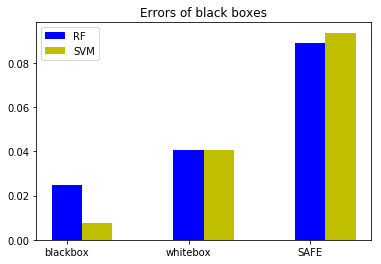

In [27]:
bar_width = 0.25

plt.figure()
plt.title("Errors of black boxes")
plt.bar(np.arange(3), 
        np.array(errors_rf),
        width = bar_width,
        color="b", 
        label="RF",
        align="center")
plt.bar(np.arange(3) + bar_width, 
        np.array(errors_svm),
        color="y", 
        width=bar_width,
        label="SVM",
        align="center")
plt.legend()
plt.xticks(np.arange(3), 
           labels=['blackbox', 'whitebox', 'SAFE'])
plt.show()

Jak widać na załączonym obrazku, metoda SAFE nie poprawiła wyników na zbiorze testowym.

Wynika to najprawodpodobniej z bardzo dobrego dopasowania modeli czarnej skrzynki oraz względnie dobrego dopasowania prostego modelu regresji liniowej, co może świadczyć o tym, że analizowane dane pochodzą z symulacji. Wówczas dyskretyzacja zmiennych prowadzi do poprawy wyników.

Ciekawym wnioskiem jest fakt, że SVM lepiej radzi sobie na zbiorze testowym, ale zmiennej zdyskretyzowane na jego podstawie dają gorsze wyniki od zmiennych powstałych na podstawie lasu losowego.